In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_test3', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k=2
cantera_species=pd.read_csv(name_11+str(Ts[k])+name_12+str(phis[k])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k])+name_22+str(phis[k])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['H2O','O2','H2','T[K]','OH','HO2','H2O2']

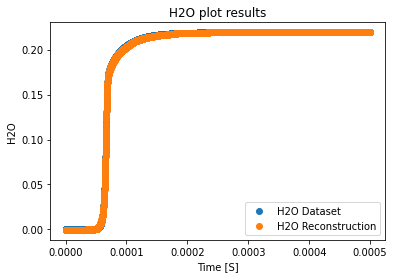

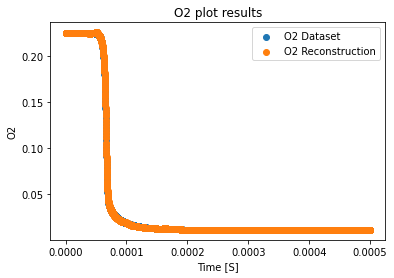

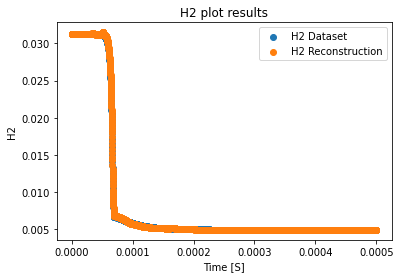

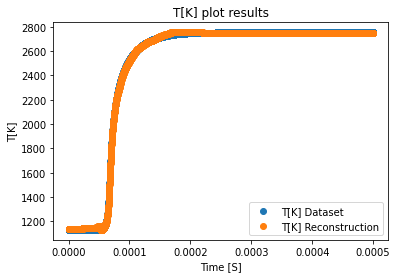

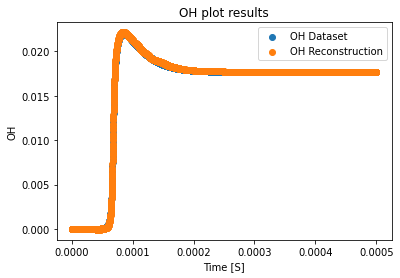

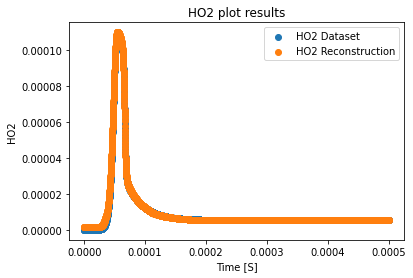

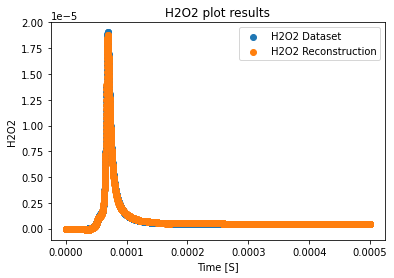

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
latent_space=Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy())).numpy()

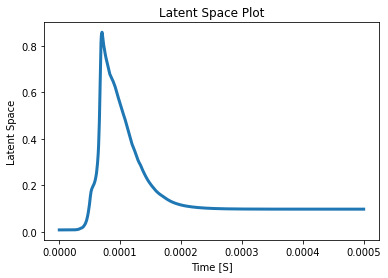

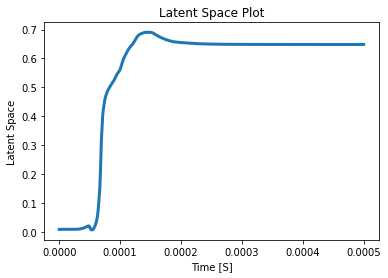

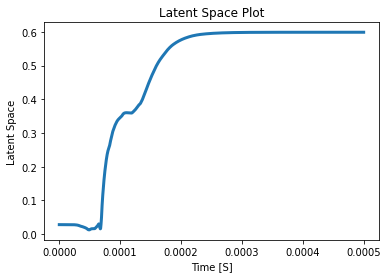

In [11]:
reduced_size=3

if reduced_size==1:
    plt.figure()
    plt.plot(time_plot,latent_space,linewidth=3)
    plt.title('Latent Space Plot')
    plt.xlabel('Time [S]')
    plt.ylabel('Latent Space')
else: 
    for i in range(reduced_size):
            plt.figure(i)
            plt.plot(time_plot,latent_space[:,i],linewidth=3)
            plt.title('Latent Space Plot')
            plt.xlabel('Time [S]')
            plt.ylabel('Latent Space')

In [12]:
corr_dataset=dataset.iloc[:,1:2+n_columns_mass_fraction+n_columns_source]
corr_columns=corr_dataset.columns.to_list()
corr_dataset

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,0.405757,0.971234,3.026851e-10,0.994361,9.347321e-12,1.329399e-11,2.724084e-13,4.589856e-07,5.596190e-11,-7.574802e-09,1.633590e-08,-1.719316e-08,1.413516e-09,1.396800e-09,6.092578e-11,3.636539e-05,5.486612e-09
1,0.405757,0.971234,6.014564e-10,0.994361,3.189426e-11,5.045361e-11,1.892945e-12,9.209433e-07,2.241949e-10,-7.713904e-09,1.621257e-08,-1.762723e-08,2.236168e-09,2.582811e-09,2.078866e-10,3.659881e-05,1.100727e-08
2,0.405757,0.971234,8.991601e-10,0.994361,6.241024e-11,1.079589e-10,5.724130e-12,1.385850e-06,5.054338e-10,-7.907737e-09,1.621198e-08,-1.805974e-08,2.768613e-09,3.600392e-09,4.067895e-10,3.683138e-05,1.656168e-08
3,0.405757,0.971234,1.197712e-09,0.994361,9.834179e-11,1.830035e-10,1.230312e-11,1.853703e-06,9.003646e-10,-8.141693e-09,1.629900e-08,-1.849348e-08,3.150110e-09,4.481558e-09,6.409912e-10,3.706461e-05,2.214983e-08
4,0.405757,0.971234,1.498501e-09,0.994361,1.383374e-10,2.733067e-10,2.201249e-11,2.324521e-06,1.409677e-09,-8.407410e-09,1.645312e-08,-1.893047e-08,3.448796e-09,5.251492e-09,9.016825e-10,3.729958e-05,2.777189e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.553975e-09,-1.103661e-08,-4.791530e-09,-3.345335e-08,-1.431179e-08,1.125345e-08,-7.830790e-09,-2.416850e-09
4995,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.538464e-09,-1.099903e-08,-4.775213e-09,-3.333937e-08,-1.426306e-08,1.121513e-08,-7.804183e-09,-2.408601e-09
4996,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.523011e-09,-1.096157e-08,-4.758951e-09,-3.322563e-08,-1.421458e-08,1.117692e-08,-7.777544e-09,-2.400436e-09
4997,0.989192,0.153838,1.399595e-01,0.050045,7.513178e-01,1.601142e-01,9.858607e-01,4.845972e-02,2.044816e-02,-4.507609e-09,-1.092424e-08,-4.742745e-09,-3.311294e-08,-1.416599e-08,1.113889e-08,-7.751061e-09,-2.392228e-09


In [13]:
iterations=np.shape(corr_dataset)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes=np.zeros(iterations) #rows, columns
    corr_indexes=np.array([corr_indexes])
    
    for j in range(iterations):
        corr_indexes[:,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space)
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)
else: 
    
    corr_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes[k,j],_=stats.kendalltau(corr_dataset.iloc[:,j],latent_space[:,k])
    corr_indexes=pd.DataFrame(corr_indexes, columns=corr_columns)

In [14]:
corr_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.603568,0.603032,0.926951,0.603114,0.864907,0.916447,-0.603114,0.895441,0.983303,-0.791673,-0.849282,-0.809016,-0.717744,-0.840330,0.835831,-0.930263,-0.845996
1,-0.144402,0.144028,0.599983,0.143947,0.667199,0.614235,-0.143947,0.427788,0.524331,-0.356034,-0.616900,-0.341337,-0.717919,-0.623471,0.368159,-0.536657,-0.620122
2,0.967365,-0.966829,-0.566213,-0.966910,-0.499012,-0.551964,0.966910,-0.737532,-0.641848,0.809968,0.494388,0.824697,0.393067,0.487561,-0.797862,0.587651,0.490716


H2O2     0.983303
H        0.926951
O        0.916447
HO2      0.895441
OH       0.864907
H2Ow     0.835831
O2       0.603114
H2       0.603032
H2O     -0.603114
T[K]    -0.603568
OHw     -0.717744
H2w     -0.791673
O2w     -0.809016
Ow      -0.840330
H2O2w   -0.845996
Hw      -0.849282
HO2w    -0.930263
Name: 0, dtype: float64
OH       0.667199
O        0.614235
H        0.599983
H2O2     0.524331
HO2      0.427788
H2Ow     0.368159
H2       0.144028
O2       0.143947
H2O     -0.143947
T[K]    -0.144402
O2w     -0.341337
H2w     -0.356034
HO2w    -0.536657
Hw      -0.616900
H2O2w   -0.620122
Ow      -0.623471
OHw     -0.717919
Name: 1, dtype: float64
T[K]     0.967365
H2O      0.966910
O2w      0.824697
H2w      0.809968
HO2w     0.587651
Hw       0.494388
H2O2w    0.490716
Ow       0.487561
OHw      0.393067
OH      -0.499012
O       -0.551964
H       -0.566213
H2O2    -0.641848
HO2     -0.737532
H2Ow    -0.797862
H2      -0.966829
O2      -0.966910
Name: 2, dtype: float64


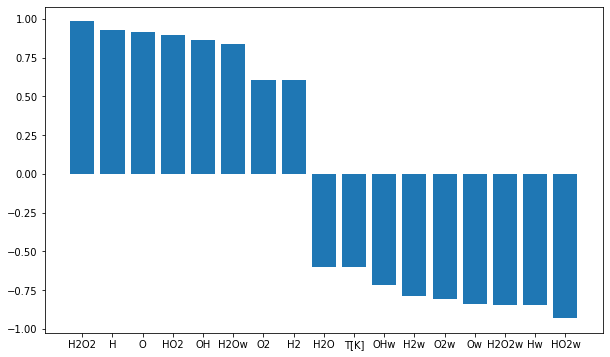

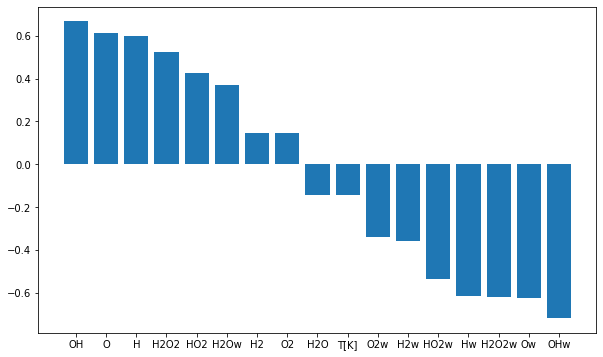

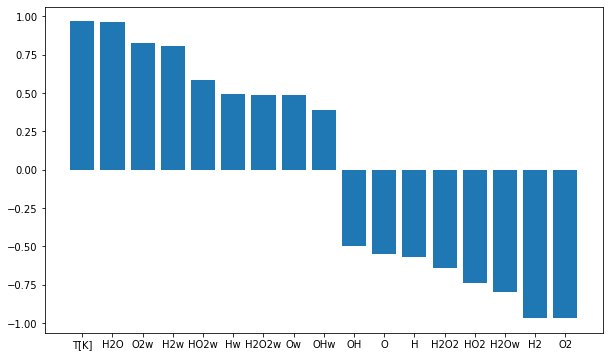

In [15]:
for m in range(reduced_size):
    
    indexes=corr_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [16]:
if reduced_size==1:
    spearman_indexes=np.zeros(iterations) #rows, columns
    spearman_indexes=np.array([spearman_indexes])
    
    for j in range(iterations):
        spearman_indexes[:,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space)
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)
else: 
    
    spearman_indexes=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            spearman_indexes[k,j],_=stats.spearmanr(corr_dataset.iloc[:,j],latent_space[:,k])
    spearman_indexes=pd.DataFrame(spearman_indexes, columns=corr_columns)

In [17]:
spearman_indexes

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.464056,0.464046,0.925640,0.464047,0.848643,0.911377,-0.464047,0.891351,0.994592,-0.816336,-0.832988,-0.839958,-0.646517,-0.819872,0.873511,-0.951743,-0.827242
1,0.124810,-0.124818,0.525969,-0.124819,0.611012,0.545013,0.124819,0.279305,0.406477,-0.193248,-0.583826,-0.172950,-0.723837,-0.593475,0.215115,-0.462270,-0.588249
2,0.995427,-0.995418,-0.361957,-0.995418,-0.269361,-0.340220,0.995418,-0.639783,-0.493241,0.824742,0.286947,0.845653,0.151226,0.277169,-0.803046,0.428709,0.282396


H2O2     0.994592
H        0.925640
O        0.911377
HO2      0.891351
H2Ow     0.873511
OH       0.848643
O2       0.464047
H2       0.464046
H2O     -0.464047
T[K]    -0.464056
OHw     -0.646517
H2w     -0.816336
Ow      -0.819872
H2O2w   -0.827242
Hw      -0.832988
O2w     -0.839958
HO2w    -0.951743
Name: 0, dtype: float64
OH       0.611012
O        0.545013
H        0.525969
H2O2     0.406477
HO2      0.279305
H2Ow     0.215115
H2O      0.124819
T[K]     0.124810
H2      -0.124818
O2      -0.124819
O2w     -0.172950
H2w     -0.193248
HO2w    -0.462270
Hw      -0.583826
H2O2w   -0.588249
Ow      -0.593475
OHw     -0.723837
Name: 1, dtype: float64
T[K]     0.995427
H2O      0.995418
O2w      0.845653
H2w      0.824742
HO2w     0.428709
Hw       0.286947
H2O2w    0.282396
Ow       0.277169
OHw      0.151226
OH      -0.269361
O       -0.340220
H       -0.361957
H2O2    -0.493241
HO2     -0.639783
H2Ow    -0.803046
H2      -0.995418
O2      -0.995418
Name: 2, dtype: float64


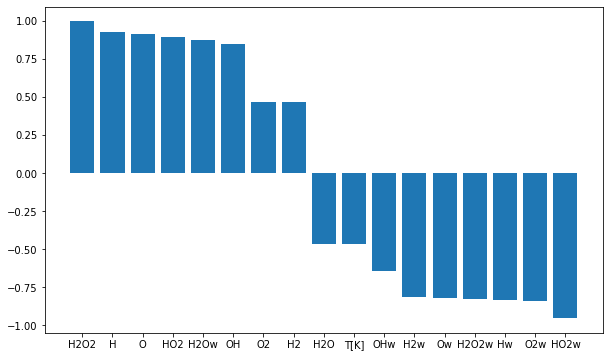

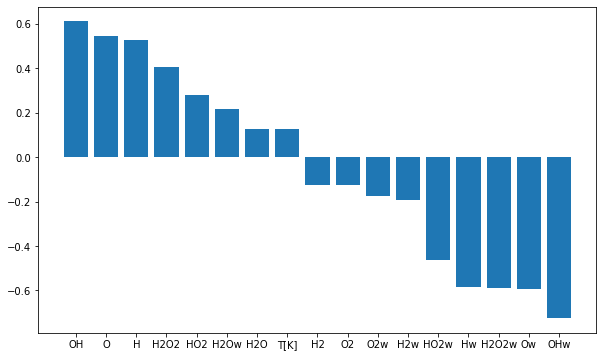

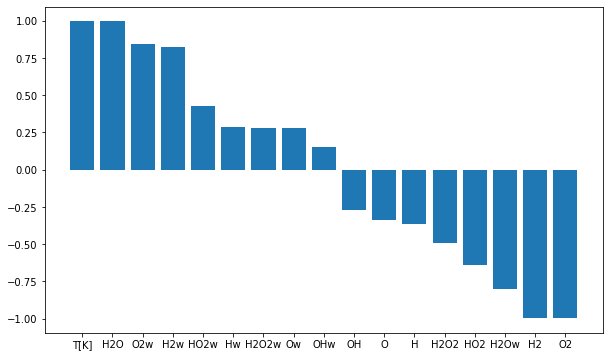

In [18]:
for m in range(reduced_size):
    
    indexes=spearman_indexes.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)

In [19]:
n_samples=np.shape(latent_space)[0]

corr_dataset_=corr_dataset.iloc[1:,:]

latent_space_=latent_space[0:n_samples-1,:]

In [59]:
print(np.shape(corr_dataset_))
print(np.shape(latent_space_))

(4998, 17)
(4998, 3)


In [60]:
iterations=np.shape(corr_dataset_)[1]

from scipy import stats 

if reduced_size==1:
    corr_indexes_=np.zeros(iterations) #rows, columns
    corr_indexes_=np.array([corr_indexes_])
    
    for j in range(iterations):
        corr_indexes_[:,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_)
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)
else: 
    
    corr_indexes_=np.zeros((reduced_size,iterations)) #rows, columns
    
    for k in range(reduced_size):
        for j in range(iterations):
            corr_indexes_[k,j],_=stats.kendalltau(corr_dataset_.iloc[:,j],latent_space_[:,k])
    corr_indexes_=pd.DataFrame(corr_indexes_, columns=corr_columns)

In [61]:
corr_indexes_

,T[K],H2,H,O2,OH,O,H2O,HO2,H2O2,H2w,Hw,O2w,OHw,Ow,H2Ow,HO2w,H2O2w
0,-0.603473,0.602952,0.927409,0.603033,0.865576,0.916953,-0.603033,0.894677,0.983556,-0.790895,-0.850048,-0.808278,-0.718489,-0.841100,0.835042,-0.930732,-0.846768
1,-0.144239,0.143881,0.599217,0.143799,0.666459,0.613474,-0.143799,0.426953,0.523535,-0.355198,-0.616249,-0.340528,-0.717335,-0.622825,0.367300,-0.535777,-0.619437
2,0.967338,-0.966817,-0.566842,-0.966898,-0.499614,-0.552587,0.966898,-0.738212,-0.642507,0.810648,0.495011,0.825353,0.393496,0.488062,-0.798566,0.588361,0.491221


H2O2     0.983556
H        0.927409
O        0.916953
HO2      0.894677
OH       0.865576
H2Ow     0.835042
O2       0.603033
H2       0.602952
H2O     -0.603033
T[K]    -0.603473
OHw     -0.718489
H2w     -0.790895
O2w     -0.808278
Ow      -0.841100
H2O2w   -0.846768
Hw      -0.850048
HO2w    -0.930732
Name: 0, dtype: float64
OH       0.666459
O        0.613474
H        0.599217
H2O2     0.523535
HO2      0.426953
H2Ow     0.367300
H2       0.143881
O2       0.143799
H2O     -0.143799
T[K]    -0.144239
O2w     -0.340528
H2w     -0.355198
HO2w    -0.535777
Hw      -0.616249
H2O2w   -0.619437
Ow      -0.622825
OHw     -0.717335
Name: 1, dtype: float64
T[K]     0.967338
H2O      0.966898
O2w      0.825353
H2w      0.810648
HO2w     0.588361
Hw       0.495011
H2O2w    0.491221
Ow       0.488062
OHw      0.393496
OH      -0.499614
O       -0.552587
H       -0.566842
H2O2    -0.642507
HO2     -0.738212
H2Ow    -0.798566
H2      -0.966817
O2      -0.966898
Name: 2, dtype: float64


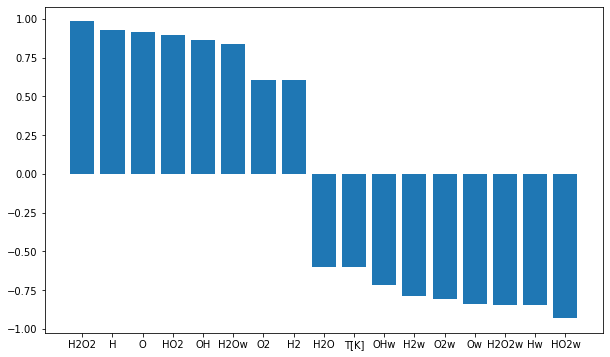

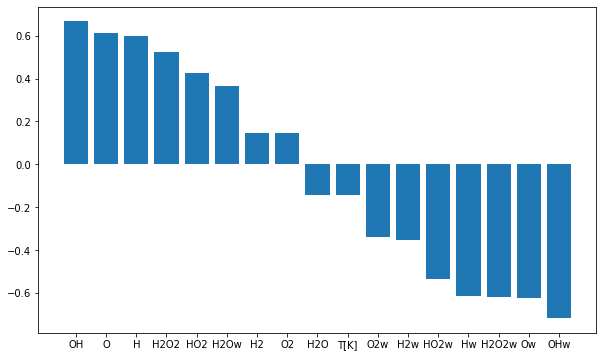

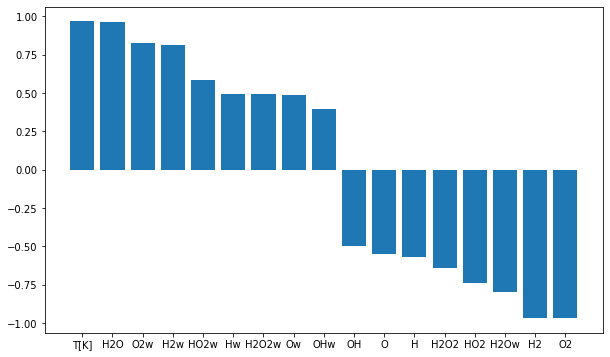

In [62]:
for m in range(reduced_size):
    
    indexes=corr_indexes_.iloc[m,:].sort_values(ascending=False)
    x=indexes.keys()
    height=indexes.iloc[:].to_numpy()
    plt.figure(m,figsize=(10, 6))
    plt.bar(x,height)
    #axes=indexes.plot.bar(x='Chemical Specie', y='Corellation Index',rot=reduced_size, subplots=True)
    #axes[1].legend(loc=reduced_size)
    print(indexes)